In [9]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import wiener
from scipy.ndimage import convolve

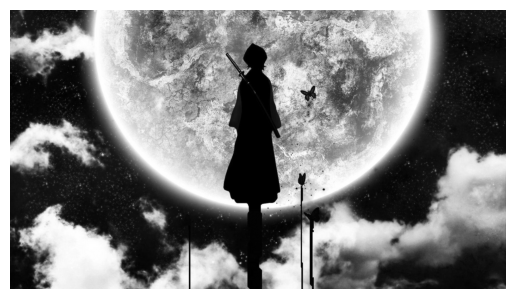

In [5]:
image = cv2.imread(r"/content/7493519.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image,cmap='gray')
plt.axis("off")
plt.show()

In [18]:
def add_noise(image, noise_type='gaussian', **kwargs):
    row, col = image.shape

    if noise_type == 'gaussian':
        mean, sigma = kwargs.get('mean', 0), kwargs.get('sigma', 25)
        noise = np.random.normal(mean, sigma, (row, col))
    elif noise_type == 'rayleigh':
        sigma = kwargs.get('sigma', 25)
        noise = np.random.rayleigh(sigma, (row, col))
    elif noise_type == 'gamma':
        shape, scale = kwargs.get('shape', 2), kwargs.get('scale', 25)
        noise = np.random.gamma(shape, scale, (row, col))
    elif noise_type == 'exponential':
        scale = kwargs.get('scale', 25)
        noise = np.random.exponential(scale, (row, col))
    elif noise_type == 'uniform':
        low, high = kwargs.get('low', -25), kwargs.get('high', 25)
        noise = np.random.uniform(low, high, (row, col))
    elif noise_type == 'impulse':
        prob = kwargs.get('prob', 0.1)
        output = np.copy(image)
        black = np.random.rand(row, col) < prob / 2
        white = np.random.rand(row, col) < prob / 2
        output[black] = 0
        output[white] = 255
        return output

    noisy = np.clip(image + noise, 0, 255)
    return noisy.astype(np.uint8)

noisy_images = {
    "Original": image,
    "Gaussian Noise": add_noise(image, 'gaussian', sigma=25),
    "Rayleigh Noise": add_noise(image, 'rayleigh', sigma=25),
    "Gamma Noise": add_noise(image, 'gamma', shape=2, scale=25),
    "Exponential Noise": add_noise(image, 'exponential', scale=25),
    "Uniform Noise": add_noise(image, 'uniform', low=-25, high=25),
    "Salt & Pepper Noise": add_noise(image, 'impulse', prob=0.1)
}

# Plot results
fig, axes = plt.subplots(7, 2, figsize=(14, 26))

for i, (title, noisy_img) in enumerate(noisy_images.items()):
    axes[i][0].imshow(noisy_img, cmap="gray")
    axes[i][0].set_title(title)
    axes[i][0].axis("off")

    axes[i][1].hist(noisy_img.ravel(), bins=256, color='black', alpha=0.6)
    axes[i][1].set_title(f"Histogram of {title} image")

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

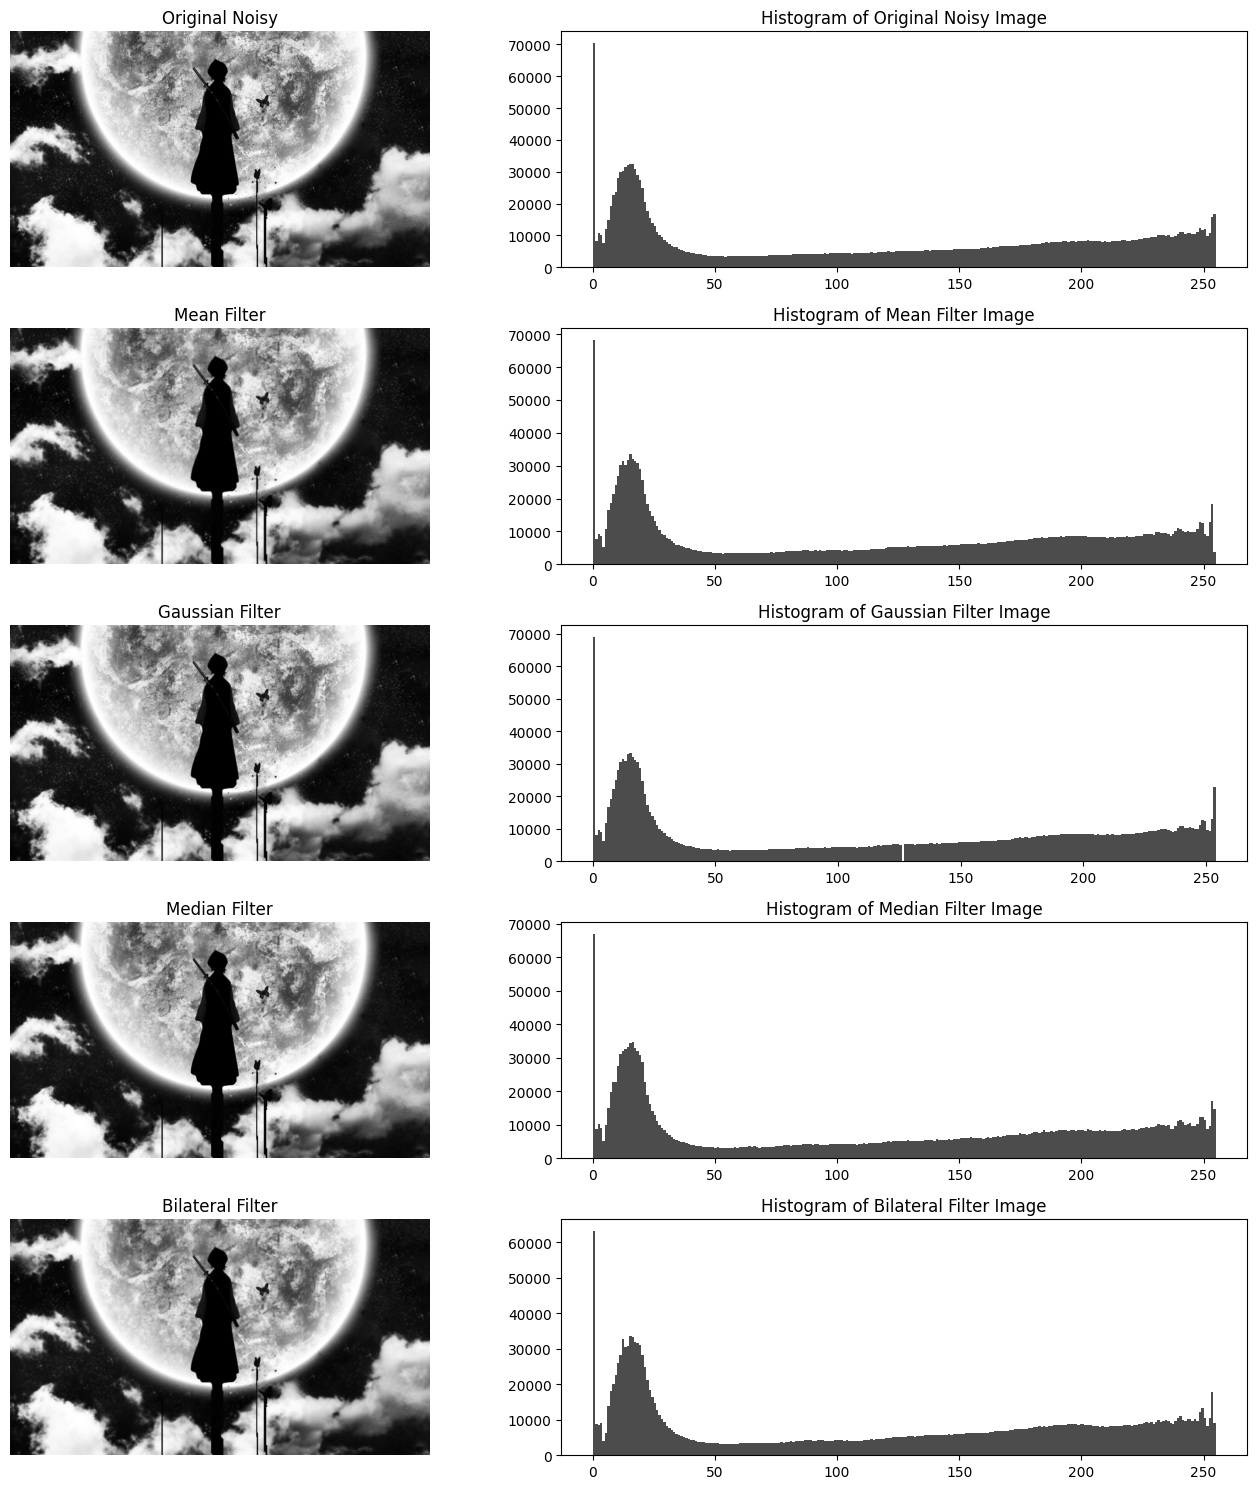

In [17]:
image = cv2.imread("/content/7493519.jpg", cv2.IMREAD_GRAYSCALE)

def apply_filter(image, kernel_size=5, sigma=1, filter_type='mean'):
    pad = kernel_size // 2
    padded_image = np.pad(image, pad, mode='edge')
    filtered_image = np.zeros_like(image)

    if filter_type == 'mean':
        func = np.mean
    elif filter_type == 'gaussian':
        x, y = np.mgrid[-pad:pad+1, -pad:pad+1]
        kernel = np.exp(-(x**2 + y**2) / (2 * sigma**2))
        kernel /= kernel.sum()
        func = lambda region: np.sum(region * kernel)
    elif filter_type == 'median':
        func = np.median
    else:
        return cv2.bilateralFilter(image, 9, 75, 75)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_image[i:i+kernel_size, j:j+kernel_size]
            filtered_image[i, j] = func(region)

    return filtered_image.astype(np.uint8)

filters = ['mean', 'gaussian', 'median']
filtered_images = [image] + [apply_filter(image, filter_type=f) for f in filters] + [cv2.bilateralFilter(image, 9, 75, 75)]

titles = ["Original Noisy", "Mean Filter", "Gaussian Filter", "Median Filter", "Bilateral Filter"]
fig, axes = plt.subplots(5, 2, figsize=(14, 15))

for i, ax in enumerate(axes):
    ax[0].imshow(filtered_images[i], cmap="gray")
    ax[0].set_title(titles[i])
    ax[0].axis("off")
    ax[1].hist(filtered_images[i].ravel(), bins=256, color='black', alpha=0.7)
    ax[1].set_title(f"Histogram of {titles[i]} Image")

plt.tight_layout()
plt.show()


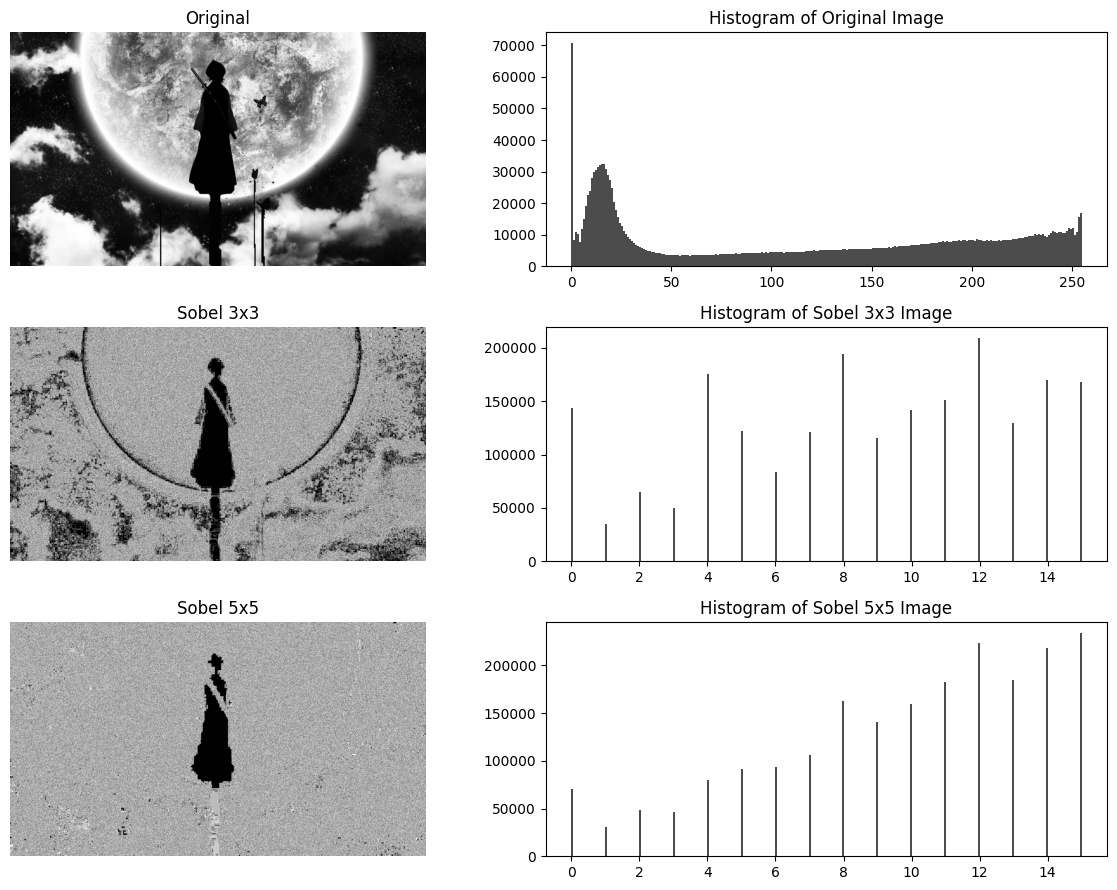

In [15]:
sobel_x_3x3 = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])
sobel_y_3x3 = np.array([[1, 2, 1],
                        [ 0, 0, 0],
                        [-1, -2, -1]])

sobel_x_5x5 = np.array([[-1, -2, 0, 2, 1],
                        [-2, -3, 0, 3, 2],
                        [-3, -5, 0, 5, 3],
                        [-2, -3, 0, 3, 2],
                        [-1, -2, 0, 2, 1]])

sobel_y_5x5 = np.array([[1, 2, 3, 2, 1],
                        [2, 3, 5, 3, 2],
                        [0, 0, 0, 0, 0],
                        [-2, -3, -5, 3, 2],
                        [-1, -2, -3, -2, -1]])

# Function to compute Sobel gradient magnitude
def sobel_gradient(image, sobel_x, sobel_y):
    grad_x = convolve(image, sobel_x)
    grad_y = convolve(image, sobel_y)
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    return np.clip(magnitude, 0, 255).astype(np.uint8)

image = cv2.imread(r"/content/7493519.jpg", cv2.IMREAD_GRAYSCALE)

# Compute Sobel magnitudes
sobel_mag_3x3 = sobel_gradient(image, sobel_x_3x3, sobel_y_3x3)
sobel_mag_5x5 = sobel_gradient(image, sobel_x_5x5, sobel_y_5x5)

# Prepare for plotting
titles = ["Original", "Sobel 3x3", "Sobel 5x5"]
images = [image, sobel_mag_3x3, sobel_mag_5x5]

# Plot the results
fig, axes = plt.subplots(3, 2, figsize=(12, 9))

for i in range(3):
    axes[i, 0].imshow(images[i], cmap="gray")
    axes[i, 0].set_title(titles[i])
    axes[i, 0].axis("off")

    axes[i, 1].hist(images[i].ravel(), bins=256, color='black', alpha=0.7)
    axes[i, 1].set_title(f"Histogram of {titles[i]} Image")

plt.tight_layout()
plt.show()
